In [2]:
import os
import pandas as pd
import string
import random
import matplotlib
import numpy as np
import coremltools
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from keras import backend as K
from ast import literal_eval
from sklearn.utils import class_weight
from keras.models import Sequential
from keras.models import load_model
from keras.metrics import top_k_categorical_accuracy
from keras.callbacks import ModelCheckpoint
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers
from livelossplot import PlotLossesKeras
from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input

TensorFlow version 2.11.0 has not been tested with coremltools. You may run into unexpected errors. TensorFlow 2.10.0 is the most recent version that has been tested.


ModuleNotFoundError: No module named 'coremltools.libmilstoragepython'

In [2]:
# Download dataset from https://www.kaggle.com/greg115/various-tagged-images
DATASET_PATH = "" # Directory of the images with the following format "id-tag1_tag2.jpg"
METADATA_PATH = DATASET_PATH+"metadata.csv"
IMAGE_PATH_KEY = "image_path"
TAGS_PATH_KEY = "tags"
MODEL_PATH = "image_tagger.h5"
IMAGE_SIZE = 224
BATCH_SIZE = 16
TESTING_SIZE = 50
VALIDATION_SPLIT = 0.01
RANDOM_SEED = 115
EPOCHS = 20
DROPOUT = 0.5
FULLY_CONNECTED = 1024
LEARNING_RATE = 0.0001
LEARNING_RATE_DECAY = LEARNING_RATE/100.0
CONFIDENCE_THRESHOLD = 0.9

In [3]:
# Loading metadata and splitting into training/validation and testing sets
df = pd.read_csv(METADATA_PATH)

training_and_validation_size = df.shape[0] - TESTING_SIZE

training_df = df[:training_and_validation_size]
testing_df = df[training_and_validation_size:]

training_df[TAGS_PATH_KEY] = training_df[TAGS_PATH_KEY].apply(lambda x:literal_eval(x))
training_df

/home/greg/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


image_path  \
0                           ejonstii3qi-animal_grey.jpg   
1       kphdeghsiy-architecture_homedecor_uk_window.jpg   
2                             26235064300-mountains.jpg   
3              qsopxqw5znc-abs_grey_mountain_nature.jpg   
4                              xeuvdo2nowi-building.jpg   
...                                                 ...   
758896             sqsadibd8ba-blue_nature_outdoors.jpg   
758897       daxb9k1lgq-horizon_nature_outdoors_sky.jpg   
758898    exjpauryqza-apparel_clothing_wedding_wood.jpg   
758899           4qt6g8aabcw-flower_spring_sunlight.jpg   
758900                    vb6jfrhp5e-brown_rug_rust.jpg   

                                         tags  
0                              [animal, grey]  
1       [architecture, homedecor, uk, window]  
2                                 [mountains]  
3               [abs, grey, mountain, nature]  
4                                  [building]  
...                                       ...  
758896               [blue, nature, outdoors]  
758897       [horizon, nature, outdoors, sky]  
758898     [apparel, clothing, wedding, wood]  
758899             [flower, spring, sunlight]  
758900                     [brown, rug, rust]  

[758901 rows x 2 columns]

In [4]:
# Getting labels
all_labels = [] 

for tags in training_df[TAGS_PATH_KEY].values.tolist():
    for tag in tags:
        all_labels.append(tag)
        
unique_labels = list(np.unique(all_labels))

In [5]:
training_data_generator = ImageDataGenerator(rotation_range=30,
                                             zoom_range=0.2,
                                             width_shift_range=0.2,
                                             height_shift_range=0.2,
                                             shear_range=0.2,
                                             horizontal_flip=True,
                                             fill_mode="nearest",
                                             validation_split=VALIDATION_SPLIT,
                                             preprocessing_function=preprocess_input)

training_generator = training_data_generator.flow_from_dataframe(dataframe=training_df,
                                                                 directory=DATASET_PATH,
                                                                 x_col=IMAGE_PATH_KEY, 
                                                                 y_col=TAGS_PATH_KEY,
                                                                 batch_size=BATCH_SIZE,
                                                                 seed=RANDOM_SEED,
                                                                 class_mode="categorical",
                                                                 target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                                 subset="training")

validation_generator = training_data_generator.flow_from_dataframe(dataframe=training_df,
                                                                   directory=DATASET_PATH,
                                                                   x_col=IMAGE_PATH_KEY,
                                                                   y_col=TAGS_PATH_KEY,
                                                                   batch_size=BATCH_SIZE,
                                                                   seed=RANDOM_SEED,
                                                                   class_mode="categorical",
                                                                   target_size=(IMAGE_SIZE, IMAGE_SIZE), 
                                                                   subset="validation")



Found 751312 validated image filenames belonging to 1120 classes.
Found 7589 validated image filenames belonging to 1120 classes.


In [6]:
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2*((p*r)/(p++K.epsilon()))

def get_model():
    def model(backbone):
        model = Sequential()
        model.add(backbone)
        model.add(GlobalAveragePooling2D())
        model.add(Dropout(DROPOUT))
        model.add(BatchNormalization())
        model.add(Dense(FULLY_CONNECTED, activation='relu'))
        model.add(Dense(len(unique_labels), activation='sigmoid'))
        model.compile(loss='binary_crossentropy',
                      optimizer=optimizers.Adam(lr=LEARNING_RATE, decay=LEARNING_RATE_DECAY),
                      metrics=["accuracy", recall, precision, f1])
        return model

    backbone = MobileNetV2(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')
    backbone.trainable = False
    return model(backbone)

model = get_model()

W0517 09:01:23.000904 140580710905664 deprecation.py:323] From /home/greg/.local/lib/python3.6/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [7]:
# Setting class weights to handle imbalanced data
class_weights = class_weight.compute_class_weight('balanced',
                                                  unique_labels,
                                                  all_labels)

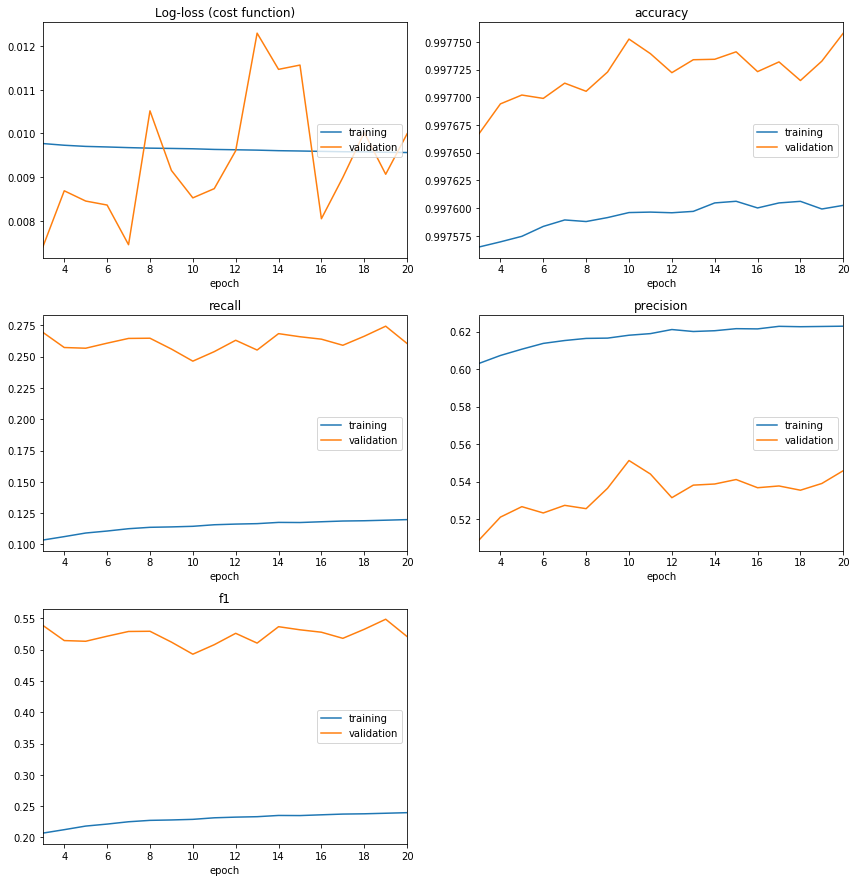

Log-loss (cost function):
training   (min:    0.010, max:    0.011, cur:    0.010)
validation (min:    0.007, max:    0.012, cur:    0.010)

accuracy:
training   (min:    0.997, max:    0.998, cur:    0.998)
validation (min:    0.998, max:    0.998, cur:    0.998)

recall:
training   (min:    0.086, max:    0.120, cur:    0.120)
validation (min:    0.246, max:    0.284, cur:    0.261)

precision:
training   (min:    0.549, max:    0.623, cur:    0.623)
validation (min:    0.457, max:    0.551, cur:    0.546)

f1:
training   (min:    0.172, max:    0.240, cur:    0.240)
validation (min:    0.493, max:    0.568, cur:    0.521)

Epoch 00020: val_f1 did not improve from 0.56847


/home/greg/.local/lib/python3.6/site-packages/keras/engine/saving.py:384: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [8]:
# Training
model.fit_generator(generator=training_generator,
                    class_weight=class_weights,
                    steps_per_epoch=training_generator.n // training_generator.batch_size,
                    validation_data=validation_generator,
                    validation_steps=validation_generator.n // validation_generator.batch_size,
                    callbacks=[PlotLossesKeras(), 
                               ModelCheckpoint(MODEL_PATH,
                                               monitor='val_f1',
                                               mode='max',
                                               save_best_only=True,
                                               verbose=1)],
                    epochs=EPOCHS)
model = load_model(MODEL_PATH, custom_objects={"f1": f1,
                                               "recall": recall,
                                               "precision": precision})

In [13]:
# Testing
testing_data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)
testing_generator = testing_data_generator.flow_from_dataframe(dataframe=testing_df,
                                                               directory=DATASET_PATH,
                                                               x_col=IMAGE_PATH_KEY,
                                                               batch_size=1,
                                                               seed=RANDOM_SEED,
                                                               shuffle=False,
                                                               class_mode=None,
                                                               target_size=(IMAGE_SIZE, IMAGE_SIZE))
predictions = model.predict_generator(testing_generator,
                                      steps=TESTING_SIZE,
                                      verbose=1)

Found 50 validated image filenames.
50/50 [==============================] - 5s 92ms/step


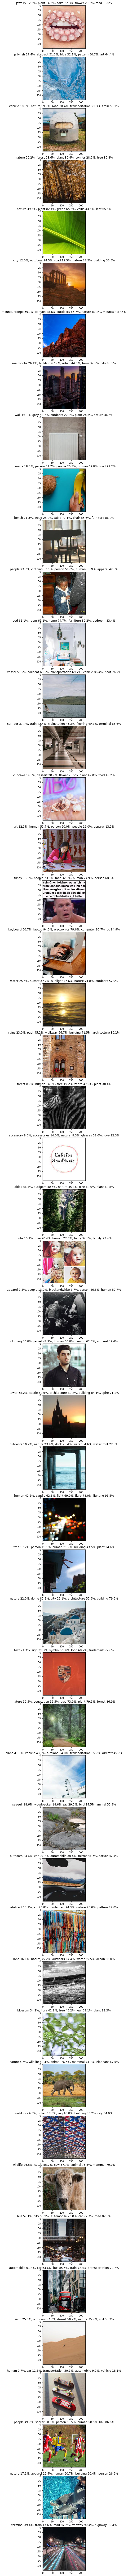

In [14]:
def show_images(images, titles, rows):
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        subplot = fig.add_subplot(rows, np.ceil(len(images)/float(rows)), n + 1)
        plt.imshow(image)
        subplot.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * len(images))
    plt.savefig("results.png", bbox_inches="tight", pad_inches=0)
    plt.show()
    plt.close()
    
images = []
titles = []

top_n = 5

for prediction_index, prediction in enumerate(predictions):
    title = ""
    top_n_indices = np.argpartition(prediction, -top_n)[-top_n:]
    for top_n_index in top_n_indices:
        if title != "":
            title += ", "
        title += (unique_labels[top_n_index] + " %.1f" % (prediction[top_n_index]*100) + "%")
            
    image_path = DATASET_PATH + testing_generator.filenames[prediction_index]
    img = mpimg.imread(image_path)
    images.append(img)
    titles.append(title)
show_images(images, titles, len(images))